In [4]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pdb
from scipy.io import loadmat
from scipy import optimize
from math import pi, log2
import warnings

In [5]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

## Helper Functions

In [79]:
def estimate_center(x, y):
    method_2 = "leastsq"

    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(x), np.mean(y)
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    return center_2

In [80]:
def get_xy(f, in_bound=True):
    x = np.squeeze(np.array(f['X']))
    y = np.squeeze(np.array(f['Y']))
    x_c, y_c = estimate_center(x, y)
    x -= x_c; y -= y_c
    length = np.sqrt(np.square(x) + np.square(y))
    frames = np.arange(x.size)
    if in_bound:
        oob = np.logical_or(length <= 145, length >= 215)
        x = x[np.logical_not(oob)]
        y = y[np.logical_not(oob)]
        frames = frames[np.logical_not(oob)]
    return x, y, frames

In [81]:
def get_theta(f):
    x, y, frames = get_xy(f, in_bound=True)
    theta = np.arctan2(y, x)
    theta = np.mod(theta, 2*pi)
    boundaries = np.linspace(0, 2*pi, 16, endpoint=False)
    boundaries = np.append(boundaries, [2*pi])
    theta = np.digitize(theta, boundaries)
    return theta, frames

In [82]:
def get_velocity(f):
    x, y, frames = get_xy(f, in_bound=False)
    delta_x = x[1:] - x[:-1]
    delta_y = y[1:] - y[:-1]
    frames = frames[1:]
    velocity = np.sqrt(np.square(delta_x) + np.square(delta_y)) # pixels/frame
    velocity = velocity*fps # pixels/s
    smoothing_kernel = np.ones(fps)/fps
    velocity = np.convolve(velocity, smoothing_kernel, "valid")
    frames = frames[:velocity.size]
    return velocity, frames

In [83]:
def get_wedges(f):
    x, y, frames = get_xy(f, in_bound=True)
    theta = np.mod(np.arctan2(y, x), 2*pi)
    boundaries = np.linspace(0, 2*pi, 16, endpoint=False)
    boundaries = np.append(boundaries, [2*pi])
    wedges = np.digitize(theta, boundaries)
    wedges = np.mod(16-wedges, 16) + 1
    return wedges, frames

In [84]:
def get_fr(spikes):
    smoothing_kernel = np.ones(fps+1)/(fps+1) # One sec smoothing
    fr = np.convolve(spikes, smoothing_kernel, "valid")
    fr_frames = np.arange(spikes.size)[
        smoothing_kernel.size//2:-smoothing_kernel.size//2+1
        ]
    return fr, fr_frames

In [85]:
def get_mutual_info(contexts, fr):
    mean_fr = np.mean(fr)
    mutual_info = 0
    for ctxt in np.unique(contexts):
        prob = np.sum(contexts==ctxt)/contexts.size
        ctxt_mean_fr = np.mean(fr[contexts==ctxt])
        try:
            log_term = log2(ctxt_mean_fr/mean_fr)
        except:
            log_term = 0
        mutual_info += prob*ctxt_mean_fr*log_term
    return mutual_info

In [86]:
def circular_shuffle(spikes):
    spikes = spikes.copy()
    shift = np.random.choice(np.arange(1, spikes.size))
    return np.roll(spikes, shift)

## Identifying place cells

In [ ]:
place_mod = 0
not_place_mod = 0
spatial_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = []
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), theta_frames)]
    spikes = np.array(f['S'])
    
    for neur in np.arange(spikes.shape[1]):
        neur_spikes = spikes[:, neur]
        neur_fr, fr_frames = get_fr(neur_spikes)
        valid_frames = np.intersect1d(fr_frames, wedge_frames)
        spatial_info = get_mutual_info(
            wedges[np.isin(wedge_frames, valid_frames)],
            neur_fr[np.isin(fr_frames, valid_frames)]
            )
        shuffled_info = []
        shuffled_peak_fr = []
        for _ in range(110):
            shuffled_spikes = circular_shuffle(neur_spikes)
            shuffled_fr, _ = get_fr(shuffled_spikes)
            shuffled_info.append(get_mutual_info(
                wedges[np.isin(wedge_frames, valid_frames)],
                shuffled_fr[np.isin(fr_frames, valid_frames)]
                ))
            shuffled_peak_fr.append(shuffled_fr.max())
        shuffled_info = np.array(shuffled_info)
        high_mutual_info = np.sum(shuffled_info < spatial_info) > 0.99*shuffled_info.size
        df = pd.DataFrame({
            "loc":wedges[np.isin(wedge_frames, valid_frames)],
            "spikerate":neur_fr[np.isin(fr_frames, valid_frames)]
            })
        spatial_infos.append(spatial_info)
        plt.figure(figsize=(10,5))
        sns.pointplot(x="loc", y="spikerate", data=df)
        if high_mutual_info:
            place_mod += 1
            plt.title("Place Cell")
            results.append(neur)
        else:
            not_place_mod += 1
            plt.title("Not Place Cell")
        plt.show()
        print(spatial_info)
with open("spatial.p", "wb") as f:
    pickle.dump(results, f)

## Identifying specific episode cells
Looking at a window around each cache. Specificity for a cache at a specific location

In [87]:
def get_cache_frames(
    cache_site, cache_sites,
    cache_frames_poke, cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_pokes = cache_frames_poke[event_idxs]
    if event_idxs.size == 1:
        cache_pokes = [cache_pokes]
    window = 30
    try:
        frames = [np.arange(c-window, c+window+1) for c in cache_pokes]
    except:
        print(cache_frames_poke)
        print(cache_site)
        print(cache_sites)
        print(cache_pokes)
        print(type(cache_pokes))
        import pdb; pdb.set_trace()
    frames = np.concatenate(frames)
    return frames.astype(int)

In [88]:
def get_noncache_frames(
    wedges, wedge_frames, cache_site,
    cache_frames, cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_frames_enter = cache_frames_enter[event_idxs]
    cache_frames_exit = cache_frames_exit[event_idxs]
    wedge_frames = wedge_frames[wedges == cache_site]
    if event_idxs.size == 1:
        cache_frames_enter = [cache_frames_enter]
        cache_frames_exit = [cache_frames_exit]
    event_frames = [
        np.arange(c, cache_frames_exit[i]) for i, c in enumerate(cache_frames_enter)
        ]
    event_frames = np.concatenate(event_frames)
    noncache = np.logical_not(np.isin(wedge_frames, cache_frames))
    nonevent = np.logical_not(np.isin(wedge_frames, event_frames))
    frames = wedge_frames[np.logical_and(noncache, nonevent)]
    return frames.astype(int)

In [15]:
cache_mod = 0
not_cache_mod = 0
cache_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = {}
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    for cache_site in np.unique(cache_sites):
        results[mat_file][cache_site] = []
        cache_frames = get_cache_frames(
            cache_site, cache_sites,
            cache_frames_poke, cache_frames_enter, cache_frames_exit
            )
        noncache_frames = get_noncache_frames(
            wedges, wedge_frames, cache_site,
            cache_frames, cache_frames_enter, cache_frames_exit
            )    
        for neur in np.arange(spikes.shape[1]):
            neur_spikes = spikes[:, neur]
            neur_fr, fr_frames = get_fr(neur_spikes)
            cf = np.intersect1d(fr_frames, cache_frames)
            ncf = np.intersect1d(fr_frames, noncache_frames)
            combined_frames = np.concatenate([cf, ncf])
            contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
            cache_info = get_mutual_info(
                contexts, neur_fr[np.isin(fr_frames, combined_frames)]
                )
            shuffled_info = []
            shuffled_peak_fr = []
            for _ in range(110):
                shuffled_spikes = circular_shuffle(neur_spikes)
                shuffled_fr, _ = get_fr(shuffled_spikes)
                shuffled_info.append(get_mutual_info(
                    contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                    ))
                shuffled_peak_fr.append(shuffled_fr.max())
            shuffled_info = np.array(shuffled_info)
            high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
            cache_infos.append(cache_info)
            if high_mutual_info:
                cache_mod += 1
                results[mat_file][cache_site].append(neur)
            else:
                not_cache_mod += 1
with open("specific_cache.p", "wb") as f:
    pickle.dump(results, f)

> <ipython-input-10-15424b41b647>(11)get_mutual_info()
-> log_term = 0
(Pdb) l
  6  	        ctxt_mean_fr = np.mean(fr[contexts==ctxt])
  7  	        try:
  8  	            log_term = log2(ctxt_mean_fr/mean_fr)
  9  	        except:
 10  	            import pdb; pdb.set_trace()
 11  ->	            log_term = 0
 12  	        mutual_info += prob*ctxt_mean_fr*log_term
 13  	    return mutual_info
[EOF]
(Pdb) log_term
0.062181576014567065
(Pdb) ctxt_mean_fr
0.0
(Pdb) mean_fr
0.05939741635105467
(Pdb) log2(ctxt_mean_fr/mean_fr)
*** ValueError: math domain error
(Pdb) c
> <ipython-input-10-15424b41b647>(11)get_mutual_info()
-> log_term = 0
(Pdb) ctxt_mean_fr
0.0
(Pdb) mean_fr
0.06931538548094138
(Pdb) c
> <ipython-input-10-15424b41b647>(11)get_mutual_info()
-> log_term = 0
(Pdb) ctxt_mean_fr
0.0
(Pdb) mean_fr
0.10268099996138955
(Pdb) np.sum(contexts==ctxt)
122
(Pdb) ncf.size
2770
(Pdb) exit()


BdbQuit: 

## Identifying general episode cells
Looking at a window around each cache. Specificity for any cache

In [89]:
def get_all_cache_frames(
    wedges, wedge_frames, cache_sites,
    cache_frames_poke, cache_frames_enter, cache_frames_exit
    ):
    
    cache_frames = []
    cache_related_frames = []
    for cache_site in np.unique(cache_sites):
        event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
        _cache_pokes = cache_frames_poke[event_idxs]
        _cache_frames_enter = cache_frames_enter[event_idxs]
        _cache_frames_exit = cache_frames_exit[event_idxs]
        if event_idxs.size == 1:
            _cache_pokes = [_cache_pokes]
            _cache_frames_enter = [_cache_frames_enter]
            _cache_frames_exit = [_cache_frames_exit]
        window = 20
        _cache_frames = [np.arange(c-window, c+window+1) for c in _cache_pokes]
        _cache_frames = np.concatenate(_cache_frames)
        cache_frames.append(_cache_frames)
        visit_frames = [
            np.arange(c, _cache_frames_exit[i]) for i, c in enumerate(_cache_frames_enter)
            ]
        visit_frames = np.concatenate(visit_frames)
        cache_related_frames.append(_cache_frames)
        cache_related_frames.append(visit_frames)
    cache_frames = np.concatenate(cache_frames)
    cache_related_frames = np.concatenate(cache_related_frames)
    
    noncache_frames = []
    for cache_site in np.unique(cache_sites):
        event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
        _cache_frames_enter = cache_frames_enter[event_idxs]
        _cache_frames_exit = cache_frames_exit[event_idxs]
        _wedge_frames = wedge_frames[wedges == cache_site]
        if event_idxs.size == 1:
            _cache_frames_enter = [_cache_frames_enter]
            _cache_frames_exit = [_cache_frames_exit]
        noncache = np.logical_not(np.isin(_wedge_frames, cache_frames))
        nonevent = np.logical_not(np.isin(_wedge_frames, cache_related_frames))
        _noncache_frames = _wedge_frames[np.logical_and(noncache, nonevent)]
        noncache_frames.append(_noncache_frames)
    noncache_frames = np.concatenate(noncache_frames)
    
    return cache_frames.astype(int), noncache_frames.astype(int)

In [ ]:
cache_mod = 0
not_cache_mod = 0
cache_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = []
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    cache_frames, noncache_frames = get_all_cache_frames(
        wedges, wedge_frames, cache_sites,
        cache_frames_poke, cache_frames_enter, cache_frames_exit
        )
    for neur in np.arange(spikes.shape[1]):
        neur_spikes = spikes[:, neur]
        neur_fr, fr_frames = get_fr(neur_spikes)
        cf = np.intersect1d(fr_frames, cache_frames)
        ncf = np.intersect1d(fr_frames, noncache_frames)
        combined_frames = np.concatenate([cf, ncf])
        contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
        cache_info = get_mutual_info(
            contexts, neur_fr[np.isin(fr_frames, combined_frames)]
            )
        shuffled_info = []
        shuffled_peak_fr = []
        for _ in range(110):
            shuffled_spikes = circular_shuffle(neur_spikes)
            shuffled_fr, _ = get_fr(shuffled_spikes)
            shuffled_info.append(get_mutual_info(
                contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                ))
            shuffled_peak_fr.append(shuffled_fr.max())
        shuffled_info = np.array(shuffled_info)
        high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
        cache_infos.append(cache_info)
        if high_mutual_info:
            cache_mod += 1
            results[mat_file].append(neur)
        else:
            not_cache_mod += 1
with open("general_cache.p", "wb") as f:
    pickle.dump(results, f)

In [ ]:
results

In [ ]:
with open("specific_cache.p", "rb") as f:
    specific_cache_results = pickle.load(f)

In [ ]:
specific_cache_results

## Control: Identifying specific episode cells
Looking at a window around each cache. Specificity for a cache at a specific location

In [90]:
def get_cache_frames(
    cache_site, cache_sites,
    cache_frames_poke, cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_pokes = cache_frames_poke[event_idxs]
    if event_idxs.size == 1:
        cache_pokes = [cache_pokes]
    window = 30
    try:
        frames = [np.arange(c-window, c+window+1) for c in cache_pokes]
    except:
        print(cache_frames_poke)
        print(cache_site)
        print(cache_sites)
        print(cache_pokes)
        print(type(cache_pokes))
        import pdb; pdb.set_trace()
    frames = np.concatenate(frames)
    return frames.astype(int)

def get_noncache_frames(
    wedges, wedge_frames, cache_site,
    cache_frames, cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_frames_enter = cache_frames_enter[event_idxs]
    cache_frames_exit = cache_frames_exit[event_idxs]
    wedge_frames = wedge_frames[wedges == cache_site]
    if event_idxs.size == 1:
        cache_frames_enter = [cache_frames_enter]
        cache_frames_exit = [cache_frames_exit]
    event_frames = [
        np.arange(c, cache_frames_exit[i]) for i, c in enumerate(cache_frames_enter)
        ]
    event_frames = np.concatenate(event_frames)
    noncache = np.logical_not(np.isin(wedge_frames, cache_frames))
    nonevent = np.logical_not(np.isin(wedge_frames, event_frames))
    frames = wedge_frames[np.logical_and(noncache, nonevent)]
    return frames.astype(int)

cache_mod = 0
not_cache_mod = 0
cache_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = {}
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    for cache_site in np.unique(cache_sites):
        results[mat_file][cache_site] = []
        cache_frames = get_cache_frames(
            cache_site, cache_sites,
            cache_frames_poke, cache_frames_enter, cache_frames_exit
            )
        noncache_frames = get_noncache_frames(
            wedges, wedge_frames, cache_site,
            cache_frames, cache_frames_enter, cache_frames_exit
            )    
        for neur in np.arange(spikes.shape[1]):
            neur_spikes = spikes[:, neur]
            neur_fr, fr_frames = get_fr(neur_spikes)
            cf = np.intersect1d(fr_frames, cache_frames)
            ncf = np.intersect1d(fr_frames, noncache_frames)
            combined_frames = np.concatenate([cf, ncf])
            contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
            for _ in range(3):
                np.random.shuffle(contexts)
            cache_info = get_mutual_info(
                contexts, neur_fr[np.isin(fr_frames, combined_frames)]
                )
            shuffled_info = []
            shuffled_peak_fr = []
            for _ in range(110):
                shuffled_spikes = circular_shuffle(neur_spikes)
                shuffled_fr, _ = get_fr(shuffled_spikes)
                shuffled_info.append(get_mutual_info(
                    contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                    ))
                shuffled_peak_fr.append(shuffled_fr.max())
            shuffled_info = np.array(shuffled_info)
            high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
            cache_infos.append(cache_info)
            if high_mutual_info:
                cache_mod += 1
                results[mat_file][cache_site].append(neur)
            else:
                not_cache_mod += 1
with open("specific_cache_shuffled.p", "wb") as f:
    pickle.dump(results, f)

/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less


KeyboardInterrupt: 

## Identifying specific episode cells by visit
Looking at the entire cache/retrieval visit. Specificity for a cache at a specific location

In [ ]:
def get_visit_frames(
    wedges, wedge_frames, cache_site,
    cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_frames_enter = cache_frames_enter[event_idxs]
    cache_frames_exit = cache_frames_exit[event_idxs]
    wedge_frames = wedge_frames[wedges == cache_site]
    if event_idxs.size == 1:
        cache_frames_enter = [cache_frames_enter]
        cache_frames_exit = [cache_frames_exit]
    visit_frames = [
        np.arange(c, cache_frames_exit[i]) for i, c in enumerate(cache_frames_enter)
        ]
    visit_frames = np.concatenate(visit_frames)
    nonvisit = np.logical_not(np.isin(wedge_frames, visit_frames))
    nonvisit_frames = wedge_frames[nonvisit]
    return visit_frames, nonvisit_frames

In [ ]:
cache_mod = 0
not_cache_mod = 0
cache_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = {}
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    for cache_site in np.unique(cache_sites):
        results[mat_file][cache_site] = []
        cache_frames, noncache_frames = get_visit_frames(
            wedges, wedge_frames, cache_site,
            cache_frames_enter, cache_frames_exit
            )
        for neur in np.arange(spikes.shape[1]):
            neur_spikes = spikes[:, neur]
            neur_fr, fr_frames = get_fr(neur_spikes)
            cf = np.intersect1d(fr_frames, cache_frames)
            ncf = np.intersect1d(fr_frames, noncache_frames)
            combined_frames = np.concatenate([cf, ncf])
            contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
            cache_info = get_mutual_info(
                contexts, neur_fr[np.isin(fr_frames, combined_frames)]
                )
            shuffled_info = []
            shuffled_peak_fr = []
            for _ in range(110):
                shuffled_spikes = circular_shuffle(neur_spikes)
                shuffled_fr, _ = get_fr(shuffled_spikes)
                shuffled_info.append(get_mutual_info(
                    contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                    ))
                shuffled_peak_fr.append(shuffled_fr.max())
            shuffled_info = np.array(shuffled_info)
            high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
            cache_infos.append(cache_info)
            if high_mutual_info:
                cache_mod += 1
                results[mat_file][cache_site].append(neur)
            else:
                not_cache_mod += 1
with open("specific_visit.p", "wb") as f:
    pickle.dump(results, f)

In [ ]:
# Using the whole visit
num_neurs = 0
for key in results.keys():
    neurs = []
    for key2 in results[key].keys():
        neurs.extend(results[key][key2])
    num_neurs += len(neurs)
    print(key)
    print(np.unique(neurs))
    print()
print("%d Total"%num_neurs)

In [ ]:
# Using a window around the cache
num_neurs = 0
for key in specific_cache_results.keys():
    neurs = []
    for key2 in specific_cache_results[key].keys():
        neurs.extend(specific_cache_results[key][key2])
    num_neurs += len(neurs)
    print(key)
    print(np.unique(neurs))
    print()
print("%d Total"%num_neurs)

In [ ]:
# Using a 30-frame window around the cache
num_neurs = 0
for key in results.keys():
    neurs = []
    for key2 in results[key].keys():
        neurs.extend(results[key][key2])
    num_neurs += len(neurs)
    print(key)
    print(np.unique(neurs))
    print()
print("%d Total"%num_neurs)

## Identifying specific episode cells by visit window
Looking at the entire cache/retrieval visit. Specificity for a cache at a specific location

In [ ]:
def get_visit_window_frames(
    wedges, wedge_frames, cache_site,
    cache_frames_enter, cache_frames_exit, cache_frames_poke
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_frames_enter = cache_frames_enter[event_idxs]
    cache_frames_exit = cache_frames_exit[event_idxs]
    cache_frames_poke = cache_frames_poke[event_idxs]
    wedge_frames = wedge_frames[wedges == cache_site]
    window = 30
    if event_idxs.size == 1:
        cache_frames_enter = [cache_frames_enter]
        cache_frames_exit = [cache_frames_exit]
        cache_frames_poke = [cache_frames_poke]
    visit_frames = [
        np.arange(enter, cache_frames_exit[i] + 1) for i, enter in enumerate(cache_frames_enter)
        ]
    visit_frames = np.concatenate(visit_frames)
    window_frames = []
    for i, enter in enumerate(cache_frames_enter):
        poke = cache_frames_poke[i]
        exit = cache_frames_exit[i]
        prepoke_time = poke - enter
        postpoke_time = exit - poke
        total_time = exit - enter
        if prepoke_time >= window and postpoke_time >= window:
            _window_frames = np.arange(poke-window, poke+window+1)
        elif prepoke_time < 30 and total_time > (window*2 + 1):
            _window_frames = np.arange(enter, enter+window*2+1)
        elif postpoke_time < 30 and total_time > (window*2 + 1):
            _window_frames = np.arange(exit-window*2, exit+1)
        else:
            _window_frames = np.arange(enter, exit+1)
        window_frames.append(_window_frames)
        
    if len(window_frames) == 0:
        return np.array([]), np.array([])
    window_frames = np.concatenate(window_frames)
    nonvisit = np.logical_not(np.isin(wedge_frames, visit_frames))
    nonvisit_frames = wedge_frames[nonvisit]
    return window_frames, nonvisit_frames

In [ ]:
cache_mod = 0
not_cache_mod = 0
cache_infos = []
results = {}
for mat_file in mat_files:
    # Load data
    results[mat_file] = {}
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    for cache_site in np.unique(cache_sites):
        results[mat_file][cache_site] = []
        cache_frames, noncache_frames = get_visit_window_frames(
            wedges, wedge_frames, cache_site,
            cache_frames_enter, cache_frames_exit, cache_frames_poke
            )
        if cache_frames.size == 0:
            results[mat_file][cache_site].append(np.nan)
            continue 
        for neur in np.arange(spikes.shape[1]):
            neur_spikes = spikes[:, neur]
            neur_fr, fr_frames = get_fr(neur_spikes)
            cf = np.intersect1d(fr_frames, cache_frames)
            ncf = np.intersect1d(fr_frames, noncache_frames)
            combined_frames = np.concatenate([cf, ncf])
            contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
            cache_info = get_mutual_info(
                contexts, neur_fr[np.isin(fr_frames, combined_frames)]
                )
            shuffled_info = []
            shuffled_peak_fr = []
            for _ in range(110):
                shuffled_spikes = circular_shuffle(neur_spikes)
                shuffled_fr, _ = get_fr(shuffled_spikes)
                shuffled_info.append(get_mutual_info(
                    contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                    ))
                shuffled_peak_fr.append(shuffled_fr.max())
            shuffled_info = np.array(shuffled_info)
            high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
            cache_infos.append(cache_info)
            if high_mutual_info:
                cache_mod += 1
                results[mat_file][cache_site].append(neur)
            else:
                not_cache_mod += 1
with open("specific_visit.p", "wb") as f:
    pickle.dump(results, f)

In [139]:
# Using a 30-frame window around the cache, restricted to within-visits
with open("specific-cache-40.p", "rb") as f:
    results = pickle.load(f)["original"]
num_neurs = 0
for key in results.keys():
    neurs = []
    for key2 in results[key].keys():
        neurs.extend(results[key][key2])
    num_neurs += len(neurs)
    print(key)
    print(np.unique(neurs))
    print()
print("%d Total"%num_neurs)

ExtractedWithXY_Cleaned184713_09102019.mat
[ 0  7 10 12 15 16 17 18 19 23 33]

ExtractedWithXY_Cleaned184430_09102019.mat
[ 7  8 11 16 43]

ExtractedWithXY_Cleaned184526_09102019.mat
[ 0  1  2  4  6  7  8  9 12 19 20 22 28 30 43]

ExtractedWithXY_Cleaned184946_09102019.mat
[ 2 18 33 34]

ExtractedWithXY_Cleaned185033_09102019.mat
[ 0  1  2 13 18 32]

ExtractedWithXY_Cleaned184331_09102019.mat
[ 4 10]

ExtractedWithXY_Cleaned144233_09112019.mat
[ 1  2  3  4  5 11 14 17 18 19 20 22 24 25 27 28 34 41 44 53]

83 Total


## Collect info

In [96]:
with open("specific-cache-40.p", 'rb') as f:
    cache_results = pickle.load(f)
cache_results = cache_results["original"]
with open("spatial.p", 'rb') as f:
    spatial_results = pickle.load(f)

In [108]:
def get_cache_frames(
    window, wedges, wedge_frames,
    cache_site, cache_sites,
    cache_frames_poke, cache_frames_enter, cache_frames_exit
    ):
    
    event_idxs = np.argwhere(cache_sites == cache_site).squeeze()
    cache_pokes = cache_frames_poke[event_idxs]
    cache_frames_enter = cache_frames_enter[event_idxs]
    cache_frames_exit = cache_frames_exit[event_idxs]
    wedge_frames = wedge_frames[wedges == cache_site]
    if event_idxs.size == 1:
        cache_pokes = [cache_pokes]
        cache_frames_enter = [cache_frames_enter]
        cache_frames_exit = [cache_frames_exit]
    cache_frames = [np.arange(c-window, c+window+1) for c in cache_pokes]
    cache_frames = np.concatenate(cache_frames)
    visit_frames = [
        np.arange(c, cache_frames_exit[i]) for i, c in enumerate(cache_frames_enter)
        ]
    visit_frames = np.concatenate(visit_frames)
    noncache = np.logical_not(np.isin(wedge_frames, cache_frames))
    nonvisit = np.logical_not(np.isin(wedge_frames, visit_frames))
    noncache_frames = wedge_frames[np.logical_and(noncache, nonvisit)]
    return cache_frames.astype(int), noncache_frames.astype(int)

In [93]:
def get_normalized_spatial_info(mat_file, neur):
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    spikes = np.array(f['S'])
    neur_spikes = spikes[:, neur]
    neur_fr, fr_frames = get_fr(neur_spikes)
    valid_frames = np.intersect1d(fr_frames, wedge_frames)
    spatial_info = get_mutual_info(
        wedges[np.isin(wedge_frames, valid_frames)],
        neur_fr[np.isin(fr_frames, valid_frames)]
        )
    shuffled_info = []
    shuffled_peak_fr = []
    for _ in range(110):
        shuffled_spikes = circular_shuffle(neur_spikes)
        shuffled_fr, _ = get_fr(shuffled_spikes)
        shuffled_info.append(get_mutual_info(
            wedges[np.isin(wedge_frames, valid_frames)],
            shuffled_fr[np.isin(fr_frames, valid_frames)]
            ))
        shuffled_peak_fr.append(shuffled_fr.max())
    shuffled_info = np.mean(shuffled_info)
    return spatial_info/shuffled_info

In [112]:
def get_normalized_cache_info(mat_file, neur):
    window = 40
    cache_infos = []
    f = h5py.File("data/" + mat_file, 'r')
    _, wedge_frames = get_wedges(f)
    wedges = np.array(f['whichWedge']).squeeze()
    wedges = wedges[np.isin(np.arange(wedges.size), wedge_frames)]
    cache_sites = np.array(f['CacheSites']).squeeze()
    cache_frames_poke = np.array(f['CacheFrames']).squeeze().astype(int) - 1
    cache_frames_enter = np.array(f['CacheFramesEnter']).squeeze().astype(int) - 1
    cache_frames_exit = np.array(f['CacheFramesExit']).squeeze().astype(int) - 1
    was_retrieval = np.array(f['ThisWasRetrieval']).squeeze().astype(bool)
    was_cache = np.logical_not(was_retrieval)
    spikes = np.array(f['S'])
    for cache_site in np.unique(cache_sites):
        cache_frames, noncache_frames = get_cache_frames(
            window, wedges, wedge_frames,
            cache_site, cache_sites,
            cache_frames_poke, cache_frames_enter, cache_frames_exit
            )
        if cache_frames.size == 0:
            continue
        neur_spikes = spikes[:, neur]
        neur_fr, fr_frames = get_fr(neur_spikes)
        cf = np.intersect1d(fr_frames, cache_frames)
        ncf = np.intersect1d(fr_frames, noncache_frames)
        combined_frames = np.concatenate([cf, ncf])
        contexts = np.concatenate([np.ones(cf.size), np.zeros(ncf.size)])
        cache_info = get_mutual_info(
            contexts, neur_fr[np.isin(fr_frames, combined_frames)]
            )
        shuffled_info = []
        shuffled_peak_fr = []
        for _ in range(110):
            shuffled_spikes = circular_shuffle(neur_spikes)
            shuffled_fr, _ = get_fr(shuffled_spikes)
            shuffled_info.append(get_mutual_info(
                contexts, shuffled_fr[np.isin(fr_frames, combined_frames)]
                ))
            shuffled_peak_fr.append(shuffled_fr.max())
        shuffled_info = np.array(shuffled_info)
        high_mutual_info = np.sum(shuffled_info < cache_info) > 0.99*shuffled_info.size
        if high_mutual_info:
            cache_infos.append(cache_info/np.mean(shuffled_info))
    return np.mean(cache_infos)

In [131]:
spatial_infos = []
cache_infos = []
for mat_file in mat_files:
    spatial_cells = spatial_results[mat_file]
    cache_cells = []
    for key in cache_results[mat_file].keys():
        cache_cells.extend(cache_results[mat_file][key])
    all_cells = spatial_cells + cache_cells
    for neur in np.unique(all_cells):
        if neur in spatial_cells:
            spatial_infos.append(get_normalized_spatial_info(mat_file, neur))
        else:
            spatial_infos.append(0)
        if neur in cache_cells:
            cache_infos.append(get_normalized_cache_info(mat_file, neur))
        else:
            cache_infos.append(0)

/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


In [ ]:
len(spatial_cell)

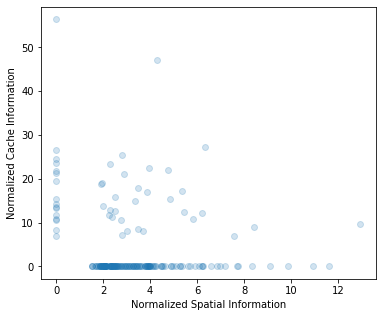

In [132]:
plt.figure(figsize=(6,5))
plt.scatter(spatial_infos, cache_infos, alpha=0.2)
plt.xlabel("Normalized Spatial Information")
plt.ylabel("Normalized Cache Information")
plt.show()

In [124]:
len(ss)

208

In [117]:
all_cells = spatial_cells + cache_cells